## Building a Spam Filter with Naive Bayes
In this project, we're going to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. Our goal is to write a program that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

To train the algorithm, we'll use a dataset of 5,572 SMS messages that are already classified by humans. The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the The UCI Machine Learning Repository. The data collection process is described in more details on this page, where you can also find some of the papers authored by Tiago A. Almeida and José María Gómez Hidalgo.

In [7]:
import pandas as pd
import numpy as np

#read in the dataset, use the 'sep' parameter to specify that the values in the dataset are separated by tabs, not commas
#use the 'header' parameter to specify that the dataset doesn't have a header row
#use the 'names' parameter to specify the names of the columns
sms_spam = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])

print(sms_spam.shape)
sms_spam.head()




(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
spam_count = sms_spam['Label'].value_counts()['spam']
ham_count = sms_spam['Label'].value_counts()['ham']

total_count = sms_spam.shape[0]

spam_percentage = (spam_count / total_count) * 100
ham_percentage = (ham_count / total_count) * 100

spam_percentage, ham_percentage

(13.406317300789663, 86.59368269921033)

Data set has 5572 rows, 2 columns 
Approximately 13% are spam and 87% are ham ('non spam')

### Training and Test Set

Letsd begin by designing the test before creating the software, to avoid potential bias. To test the spam filter, we're first going to split our dataset into two categories:

- A training set, which we'll use to "train" the computer how to classify messages.
- A test set, which we'll use to test how good the spam filter is with classifying new messages.

We can keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

- The training set will have 4,458 messages (about 80% of the dataset).
- The test set will have 1,114 messages (about 20% of the dataset).

In [9]:
#Start by randomizing the entire dataset to ensure that spam and ham messages are spread properly throughout the dataset.
#Use the DataFrame.sample() method to shuffle the entire dataset.
sms_spam_randomized = sms_spam.sample(frac=1, random_state=1)       
#calculate index for split
training_test_index = round(len(sms_spam_randomized) * 0.8)

#split the dataset into a training and a test set
#80% of the dataset is used for training, and 20% for testing
training_set = sms_spam_randomized[:training_test_index].reset_index(drop=True)
test_set = sms_spam_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)


(4458, 2)
(1114, 2)


We can now check the percentage of spam and ham in both the training and the test set.

In [10]:
#calculate the percentage of spam and ham messages in the training and test sets
spam_count_training = training_set['Label'].value_counts()['spam'] #number of spam messages in the training set
ham_count_training = training_set['Label'].value_counts()['ham'] #number of ham messages in the training set

spam_percentage_training = (spam_count_training / training_set.shape[0]) * 100 #percentage of spam messages in the training set
ham_percentage_training = (ham_count_training / training_set.shape[0]) * 100 #percentage of ham messages in the training set

spam_count_test = test_set['Label'].value_counts()['spam'] #number of spam messages in the test set
ham_count_test = test_set['Label'].value_counts()['ham'] #number of ham messages in the test set

spam_percentage_test = (spam_count_test / test_set.shape[0]) * 100 #percentage of spam messages in the test set
ham_percentage_test = (ham_count_test / test_set.shape[0]) * 100 #percentage of ham messages in the test set

print(spam_percentage_training, ham_percentage_training)
print(spam_percentage_test, ham_percentage_test)



13.458950201884253 86.54104979811575
13.195691202872531 86.80430879712748


### Data Cleaning

To use Naive Bayes algorthim we would need to clean the data so it changes from the this table

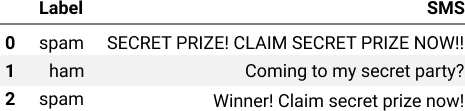

to this table

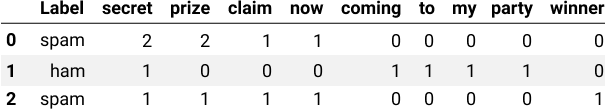

ie. 
- The SMS column doesn't exist anymore.
- Instead, the SMS column is replaced by a series of new columns, where each column represents a unique word from the vocabulary.
- Each row describes a single message. For instance, the first row corresponds to the message "SECRET PRIZE! CLAIM SECRET PRIZE NOW!!", and it has the values spam, 2, 2, 1, 1, 0, 0, 0, 0, 0. These values tell us that:

- The message is spam.
- The word "secret" occurs two times inside the message.
- The word "prize" occurs two times inside the message.
- The word "claim" occurs one time inside the message.
- The word "now" occurs one time inside the message.
- The words "coming", "to", "my", "party", and "winner" occur zero times inside the message.

- All words in the vocabulary are in lower case, so "SECRET" and "secret" come to be considered to be the same word.
- Punctuation is not taken into account anymore (for instance, we can't look at the table and conclude that the first message initially had three exclamation marks).

In [12]:
# Before cleaning
training_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


In [11]:
# remove the punctuation and make all the words lowercase
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head()


C:\Users\saqib\AppData\Local\Temp\ipykernel_32932\1579314026.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')


,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


### Creating a Vocabulary

We can create a vocabulary for the messages in the training set.

In [13]:
#transform the training set into a set of unique words
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)

vocabulary = list(set(vocabulary))

len(vocabulary)

#We can now use the vocabulary to make the data transformation we want.

word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary} #initialize the dictionary with 0s

for index, sms in enumerate(training_set['SMS']): #loop over the messages

    for word in sms: #loop over the words in each message
        word_counts_per_sms[word][index] += 1 #increment the value at the corresponding index

word_counts = pd.DataFrame(word_counts_per_sms) #transform the dictionary into a DataFrame
word_counts.head() #display the DataFrame


,nobody,cthen,bar,doesdiscount,w,seeing,messages,sorrow,adam,conducts,...,misfits,fireplace,oxygen,psychic,box334,asking,forth,fit,distract,sonyericsson
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We have 7783 unique values

In [14]:
#Concatenate the DataFrame we just built above with the DataFrame containing the training set (this way, we'll also have the Label and the SMS columns). 
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()


,Label,SMS,nobody,cthen,bar,doesdiscount,w,seeing,messages,sorrow,...,misfits,fireplace,oxygen,psychic,box334,asking,forth,fit,distract,sonyericsson
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Calculating Constants First

The Naive Bayes algorithm will need to know the probability values of the two equations below to be able to classify new messages:


\begin{equation}
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam)
\end{equation}

\begin{equation}
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
\end{equation}


Also, to calculate P(w<sub>i</sub>|Spam) and P(w<sub>i</sub>|Ham) inside the formulas above, we'll need to use these equations:

\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation}

\begin{equation}
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}


Some of the terms in the four equations above will have the same value for every new message. We can calculate the value of these terms once and avoid doing the computations again when a new messages comes in. Below, we'll use our training set to calculate:

- P(Spam) and P(Ham)
- N<sub>Spam</sub>, N<sub>Ham</sub>, N<sub>Vocabulary</sub>

We'll also use Laplace smoothing and set $\alpha = 1$.



In [15]:
# Isolating spam and ham messages first
spam_count_training = training_set['Label'].value_counts()['spam'] # number of spam messages in the training set
ham_count_training = training_set['Label'].value_counts()['ham'] # number of ham messages in the training set

total_count_training = training_set.shape[0] # total number of messages in the training set

# P(Spam) and P(Ham)
p_spam = spam_count_training / total_count_training # P(Spam)
p_ham = ham_count_training / total_count_training # P(Ham)

p_spam, p_ham


(0.13458950201884254, 0.8654104979811574)

In [18]:
# N_Spam and N_Ham
N_spam = training_set_clean['Label'].value_counts()['spam'] # number of spam messages
N_ham = training_set_clean['Label'].value_counts()['ham'] # number of ham messages

N_vocabulary = len(training_set_clean.columns) - 3 # number of unique words in the vocabulary (excluding 'Label', 'SMS', and 'index' columns)
# N_Vocabulary
N_spam, N_ham, N_vocabulary

# Laplace smoothing
alpha = 1

### Calculating Parameters

We can now calculate the parameters $P(w_i|Spam)$ and $P(w_i|Ham)$. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas:

\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation}

\begin{equation}
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

In [19]:
#initate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary} #initialize the dictionary with 0s
parameters_ham = {unique_word:0 for unique_word in vocabulary} #initialize the dictionary with 0s

#calculate parameters
for word in vocabulary:
    n_word_given_spam = training_set_clean[word][training_set_clean['Label'] == 'spam'].sum()   # spam_messages already defined
    p_word_given_spam = (n_word_given_spam + alpha) / (N_spam + alpha*N_vocabulary)  # Laplace smoothing
    parameters_spam[word] = p_word_given_spam # update the dictionary with the parameter 
    
    n_word_given_ham = training_set_clean[word][training_set_clean['Label'] == 'ham'].sum()   # ham_messages already defined
    p_word_given_ham = (n_word_given_ham + alpha) / (N_ham + alpha*N_vocabulary) # Laplace smoothing
    parameters_ham[word] = p_word_given_ham # update the dictionary with the parameter

### Classifying a New Message

Now that we've calculated all the constants and parameters we need, we can start creating the spam filter. The spam filter can be understood as a function that:

- Takes in as input a new message (w1, w2, ..., wn)
- Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn)
- Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
- If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
- If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
- If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.


In [26]:
import re

def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    '''    
    message: a string
    '''

    p_spam_given_message  =p_spam 
    p_ham_given_message = p_ham 

    #We can ignore the denominator (P(w)), because it's the same for both equations.
    #We can compare p_spam_given_message with p_ham_given_message and classify the message based on which probability is greater.

    #If p_ham_given_message is greater, then the message is classified as ham.
    #If p_spam_given_message is greater, then the message is classified as spam.
    #If the two probabilities are equal, then we may need a human to classify the message.

    for word in message:
        if  word is  parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [27]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 0.13458950201884254
P(Ham|message): 1.0254907312904032e-20
Label: Spam


In [28]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 0.13458950201884254
P(Ham|message): 6.257394085869141e-16
Label: Spam


### Measuring the Spam Filter's Accuracy

We'll now try to determine how well the spam filter does on our test set of 1,114 messages.
Note that, in training, our algorithm didn't see these 1,114 messages, so every message in the test set is practically new from the perspective of the algorithm.

In [29]:
#we'll change the classify() function that we wrote previously to return the labels instead of printing them. 
#We'll call this function classify_test_set().

def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [30]:
#Now that we have a function that returns labels instead of printing them, we can use it to create a new column in our test set.

test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Now, we'll write a function to measure the accuracy of our spam filter to find out how well our spam filter does.

In [31]:
correct = 0
total = test_set.shape[0]
    
for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
        
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1073
Incorrect: 41
Accuracy: 0.9631956912028725


The accuracy is close to 98.74%!. Our spam filter looked at 1,114 messages that it hasn't seen in training, and classified 1,100 correctly.

#### Next Steps
In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set we used, which is a pretty good result. Our initial goal was an accuracy of over 80%, and we managed to do way better than that.

Next steps include:

Analyze the 14 messages that were classified incorrectly and try to figure out why the algorithm classified them incorrectly
Make the filtering process more complex by making the algorithm sensitive to letter case